In [ ]:
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers.convolutional import MaxPooling2D
from keras.layers import Activation, Conv2D, Flatten, Dense,Dropout
from sklearn.model_selection import train_test_split
from keras.optimizers import SGD, Adadelta, Adagrad, Adam, Adamax, RMSprop, Nadam
from PIL import Image
import numpy as np
import glob
import matplotlib.pyplot as plt
import time
import os

In [ ]:
folder = os.listdir("drive/My Drive/images")
if '.ipynb_checkpoints' in folder:
  folder.remove('.ipynb_checkpoints')
image_size = 50
dense_size  = len(folder)

X = []
Y = []
for index, name in enumerate(folder):
  dir = "./drive/My Drive/images/" + name
  files = glob.glob(dir + "/*.png")
  for i, file in enumerate(files):
    image = Image.open(file) # 画像ファイルを読み込み
    image = image.convert("RGB")
    image = image.resize((image_size, image_size))
    img_array = np.asarray(image) # N次元配列に変換 asが付くと参照コピー
    X.append(img_array)
    Y.append(index)
    # increase(X, Y, img_array, index)

X = np.array(X)
Y = np.array(Y)
X = X.astype('float32')
X = X / 255.0

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.10)

In [ ]:
import cv2
from keras.preprocessing.image import ImageDataGenerator, array_to_img
# https://keras.io/ja/preprocessing/image/

def increase(X, Y, img_array, index):

  # ndarrayとして読み込まれる。RGBではなく、BGRとして読み込まれる
  # img_array = cv2.imread("./drive/My Drive/images/food/curry.png") 
  # img_array = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)
  img_array = img_array.reshape((1,) + img_array.shape)  # 4次元データに変換（flow()に渡すため)

  datagen = ImageDataGenerator(
          horizontal_flip=True,
          fill_mode='nearest'
          )

  # flow()により、ランダム変換したイメージのバッチを作成。
  i = 0
  for batch in datagen.flow(img_array, batch_size=1, save_format='png'):
    img_array = array_to_img(batch[0])
    img_array = np.array(img_array)
    # plt.imshow(img_array)
    # plt.show()
    i += 1
    if i == 100:
      break
    X.append(img_array)
    Y.append(index)

In [ ]:
# 32bit にキャスト
x_train, x_test = x_train.astype('float32'), x_test.astype('float32')
y_train, y_test = y_train.astype('int32'), y_test.astype('int32')

In [ ]:
x_train

In [ ]:
import os, random
import tensorflow as tf

def reset_seed(seed=0):
    os.environ['PYTHONHASHSEED'] = '0'
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

In [ ]:
from tensorflow.keras.applications import resnet, VGG16

# 学習済みモデルVGG16をインスタンス化
# VGG16 では画像サイズ (224, 224, 3) の画像で事前学習されている
# include_top=False 事前学習済みの全結合層を除く(ImageNet では 1000 クラス分類ですが、今回は 10 クラス分類なので最終層に全結合層を自分の問題設定に合うように追加)
# weights='imagenet' 事前学習済みの重みを引き継ぐ
base_model = VGG16(input_shape=(224, 224, 3),
                                      include_top=False, weights='imagenet')

In [ ]:
#画像のサイズ(32, 32, 3)をVGG16の学習サイズ(224, 224, 3)に大きくする
import cv2

_train, _test = [], []
for img in x_train:
    _train.append(cv2.resize(src=img, dsize=(224, 224)))
for img in x_test:    
    _test.append(cv2.resize(src=img, dsize=(224, 224)))

# リストから ndarray に変換し、正規化
x_train = np.array(_train, dtype='float32') / 255.0
x_test = np.array(_test, dtype='float32') / 255.0
x_train.shape, x_test.shape

((36, 224, 224, 3), (4, 224, 224, 3))

In [ ]:
from tensorflow.keras import models,layers

reset_seed(0)

# 全結合層の追加
# Flattenの代わりに、GlobalAveragePooling2Dを使う（学習すべきパラメータ数を減らすため）
finetuned_model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(512, activation='relu'),
    layers.Dense(10, activation='softmax')
])

In [ ]:
optimizer = tf.keras.optimizers.SGD(lr=0.01)
finetuned_model.compile(optimizer=optimizer,
                        loss='sparse_categorical_crossentropy',
                        metrics=['accuracy'])
finetuned_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_3 (Dense)              (None, 10)                5130      
Total params: 14,982,474
Trainable params: 14,982,474
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# 学習前の正解率
loss, accuracy = finetuned_model.evaluate(x_test, y_test)

1/1 [==============================] - 0s 2ms/step - loss: 2.4041 - accuracy: 0.0000e+00


In [ ]:
print(f'loss : {loss}, acuracy : {accuracy}')
# 水増し前　loss : 2.015674114227295, acuracy : 0.75

loss : 2.321043014526367, acuracy : 0.0


In [ ]:
history = finetuned_model.fit(x_train, y_train, 
                    epochs=10, 
                    batch_size=32,
                    validation_data=(x_test, y_test))

Epoch 1/10
2/2 [==============================] - 1s 535ms/step - loss: 2.2337 - accuracy: 0.0000e+00 - val_loss: 2.3655 - val_accuracy: 0.2500
Epoch 2/10
2/2 [==============================] - 0s 192ms/step - loss: 1.5097 - accuracy: 0.5278 - val_loss: 0.6486 - val_accuracy: 0.7500
Epoch 3/10
2/2 [==============================] - 0s 198ms/step - loss: 1.2326 - accuracy: 0.4722 - val_loss: 0.8319 - val_accuracy: 0.7500
Epoch 4/10
2/2 [==============================] - 0s 193ms/step - loss: 0.9721 - accuracy: 0.5833 - val_loss: 2.0634 - val_accuracy: 0.2500
Epoch 5/10
2/2 [==============================] - 0s 195ms/step - loss: 1.2673 - accuracy: 0.5278 - val_loss: 0.6798 - val_accuracy: 0.7500
Epoch 6/10
2/2 [==============================] - 0s 196ms/step - loss: 0.8769 - accuracy: 0.4722 - val_loss: 0.6854 - val_accuracy: 0.7500
Epoch 7/10
2/2 [==============================] - 0s 196ms/step - loss: 0.7295 - accuracy: 0.5278 - val_loss: 2.1669 - val_accuracy: 0.2500
Epoch 8/10
2/2 [

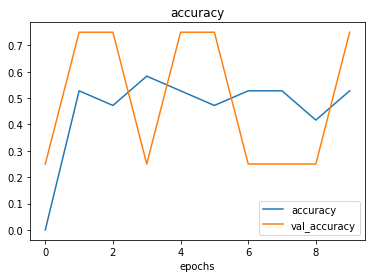

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

results = pd.DataFrame(history.history)
results[['accuracy', 'val_accuracy']].plot(title='accuracy')
plt.xlabel('epochs');